## Credit / Home Loans 

dataset: (https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset).

# Import libraries

In [111]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, auc, classification_report, roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import scikitplot as skplt
from yellowbrick.model_selection import FeatureImportances
import scipy.stats as stats
import joblib
import os

In [2]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Get the data

## import csv file

In [82]:
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')

In [83]:
print("Train features shape:", train.shape)
print("Test features shape:", test.shape)

Train features shape: (614, 13)
Test features shape: (367, 12)


In [84]:
train['Dependents'].value_counts()

Dependents
0     345
1     102
2     101
3+     51
Name: count, dtype: int64

## Data clean up

In [88]:
# train.replace({
#     'Credit_History': {1.0: 'Good', 0.0: 'Bad'}
# }, inplace=True)

# test.replace({
#     'Credit_History': {1.0: 'Good', 0.0: 'Bad'}
# }, inplace=True)

## Split the data into training and test sets

In [89]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [90]:
loan_train_original, loan_test_original = data_split(train, 0.2)

In [91]:
train_copy, test_copy = loan_train_original.copy(), loan_test_original.copy()

In [92]:
train_copy.shape, test_copy.shape

((491, 13), (123, 13))

# Explore the data

## Quick glance at the data

In [93]:
pd.set_option('display.max_columns', None)
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128000.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66000.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120000.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141000.0,360.0,1.0,Urban,Y


In [94]:
pd.set_option('display.max_columns', None)
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,NaN,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,128000000.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,66000000.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,120000000.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,141000000.0,360.0,1.0,Urban


In [95]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [96]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            367 non-null    object 
 1   Gender             356 non-null    object 
 2   Married            367 non-null    object 
 3   Dependents         357 non-null    object 
 4   Education          367 non-null    object 
 5   Self_Employed      344 non-null    object 
 6   ApplicantIncome    367 non-null    int64  
 7   CoapplicantIncome  367 non-null    int64  
 8   LoanAmount         353 non-null    float64
 9   Loan_Amount_Term   361 non-null    float64
 10  Credit_History     338 non-null    float64
 11  Property_Area      367 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


In [98]:
test.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,367.000000,367.000000,3.530000e+02,361.000000,338.000000
mean,4805.599455,1569.577657,1.452011e+08,342.537396,0.825444
std,4910.685399,2334.232099,8.397170e+07,65.156643,0.380150
min,0.000000,0.000000,1.700000e+07,6.000000,0.000000
25%,2864.000000,0.000000,1.000000e+08,360.000000,1.000000
50%,3786.000000,1025.000000,1.270000e+08,360.000000,1.000000
75%,5060.000000,2430.500000,1.680000e+08,360.000000,1.000000
max,72529.000000,24000.000000,7.000000e+08,480.000000,1.000000


## Sweetviz

In [51]:
# autoEDA = sweetviz.analyze(train)
# autoEDA.show_notebook()

## Univariate analysis

In [52]:
#Function that will return the value count and frequency of each observation within a column
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

### Property Area

In [69]:
value_cnt_norm_cal(train, 'Property_Area')

,Count,Frequency (%)
Property_Area,,
Semiurban,233,37.947883
Urban,202,32.899023
Rural,179,29.153094


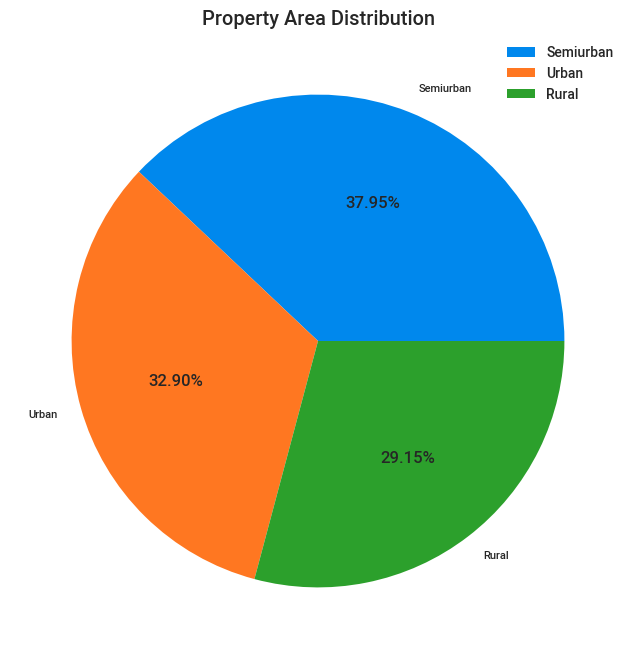

In [71]:
fig, ax = plt.subplots(figsize=(8,8))
plt.pie(train['Property_Area'].value_counts(), labels=train['Property_Area'].value_counts().index, autopct='%1.2f%%')
plt.title('Property Area Distribution')
plt.legend(loc='upper right')
plt.show()

### Gender

In [32]:
value_cnt_norm_cal(train, 'Gender')

,Count,Frequency (%)
Gender,,
Male,489,81.364393
Female,112,18.635607


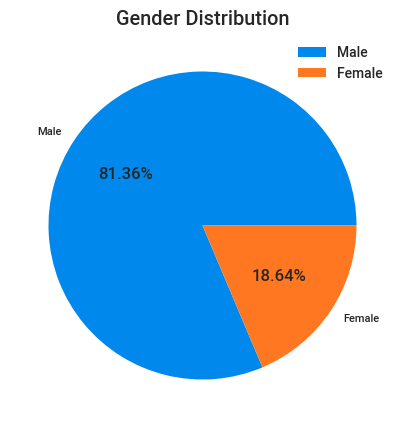

In [33]:
fig, ax = plt.subplots(figsize=(5,5))
plt.pie(train['Gender'].value_counts(), labels=train['Gender'].value_counts().index, autopct='%1.2f%%')
plt.title('Gender Distribution')
plt.legend(loc='upper right')
plt.show()

### Gender distribution loan status

In [37]:
train.groupby('Gender')['Loan_Status'].value_counts(normalize=True)

Gender  Loan_Status
Female  Y              0.669643
        N              0.330357
Male    Y              0.693252
        N              0.306748
Name: proportion, dtype: float64

### Married Status 

In [35]:
value_cnt_norm_cal(train, 'Married')

,Count,Frequency (%)
Married,,
Yes,398,65.139116
No,213,34.860884


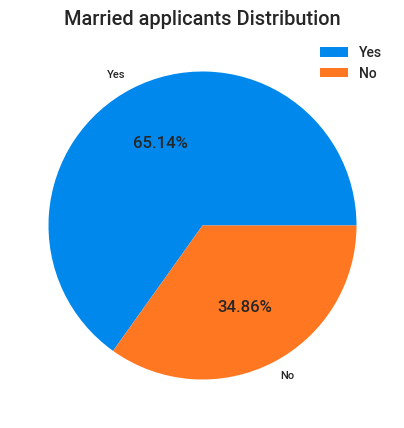

In [36]:
fig, ax = plt.subplots(figsize=(5,5))
plt.pie(train['Married'].value_counts(), labels=train['Married'].value_counts().index, autopct='%1.2f%%')
plt.title('Married applicants Distribution')
plt.legend(loc='upper right')
plt.show()

#### Married applicants loan status

In [38]:
train.groupby('Married')['Loan_Status'].value_counts(normalize=True)

Married  Loan_Status
No       Y              0.629108
         N              0.370892
Yes      Y              0.716080
         N              0.283920
Name: proportion, dtype: float64

### Dependents

In [39]:
value_cnt_norm_cal(train, 'Dependents')

,Count,Frequency (%)
Dependents,,
0,345,57.595993
1,102,17.028381
2,101,16.861436
3+,51,8.514190


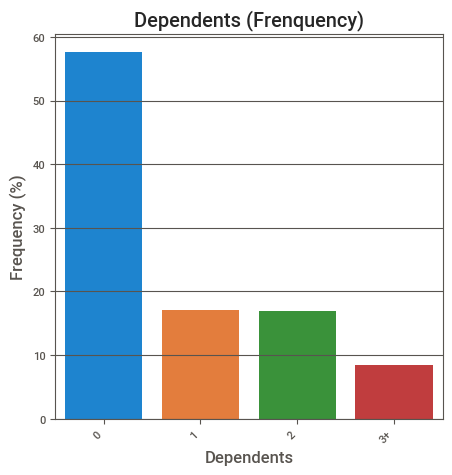

In [40]:
fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(x=value_cnt_norm_cal(train,'Dependents').index, y=value_cnt_norm_cal(train,'Dependents')['Frequency (%)'])
plt.title('Dependents (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

Interpretation:
- Most applicants have have no dependents
- Then 1 and 2 dependents are the second most common
- Then 3+ dependents

### Education

In [44]:
value_cnt_norm_cal(train, 'Education')

,Count,Frequency (%)
Education,,
Graduate,480,78.175896
Not Graduate,134,21.824104


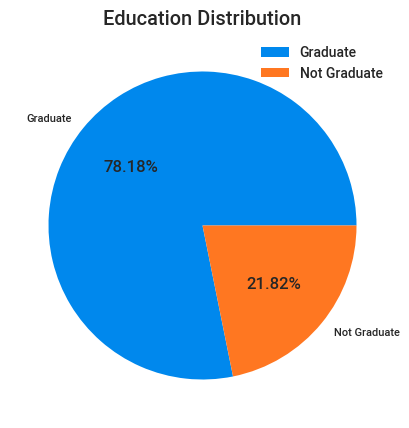

In [48]:
fig, ax = plt.subplots(figsize=(5,5))
plt.pie(train['Education'].value_counts(), labels=train['Education'].value_counts().index, autopct='%1.2f%%')
plt.title('Education Distribution')
plt.legend(loc='upper right')
plt.show()

### Self Employed

In [46]:
value_cnt_norm_cal(train, 'Self_Employed')

,Count,Frequency (%)
Self_Employed,,
No,500,85.910653
Yes,82,14.089347


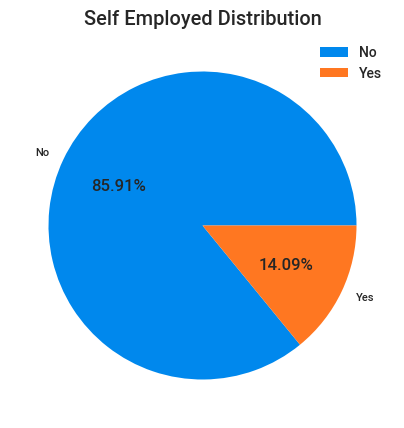

In [47]:
fig, ax = plt.subplots(figsize=(5,5))
plt.pie(train['Self_Employed'].value_counts(), labels=train['Self_Employed'].value_counts().index, autopct='%1.2f%%')
plt.title('Self Employed Distribution')
plt.legend(loc='upper right')
plt.show()

#### Question: How do the incomes of those who are employed compare to those who are self employed based on the historical dataset?

In [63]:
train.groupby('Self_Employed')['ApplicantIncome'].describe()

,count,mean,std,min,25%,50%,75%,max
Self_Employed,,,,,,,,
No,500.0,5049.748000,5682.895810,150.0,2824.50,3705.5,5292.75,81000.0
Yes,82.0,7380.817073,5883.564795,674.0,3452.25,5809.0,9348.50,39147.0


**Overview**: Self-employed individuals in this dataset have a higher average and median income compared to their employed counterparts. However, the maximum income for employed individuals is significantly higher than that of the self-employed group. The data also shows a wide range of incomes within both groups, as indicated by the standard deviation and the spread between the minimum and maximum values.

### Applicant Income 

In [50]:
train['ApplicantIncome'].describe()

count      614.000000
mean      5403.459283
std       6109.041673
min        150.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64

In [83]:
train['ApplicantIncome'].skew()

6.539513113994625

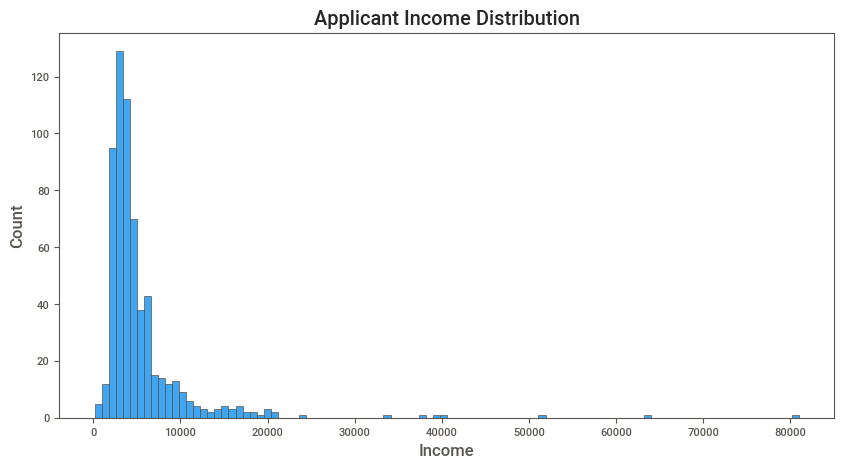

In [90]:
fig, ax = plt.subplots(figsize=(10,5))
ax.ticklabel_format(style='plain')
sns.histplot(train['ApplicantIncome'],bins=100)
plt.title('Applicant Income Distribution')
plt.xlabel('Income')
plt.show()

### CoApplicant Income

In [54]:
train['CoapplicantIncome'].describe()

count      614.000000
mean      1621.245798
std       2926.248369
min          0.000000
25%          0.000000
50%       1188.500000
75%       2297.250000
max      41667.000000
Name: CoapplicantIncome, dtype: float64

In [84]:
train['CoapplicantIncome'].skew()

7.491531216657306

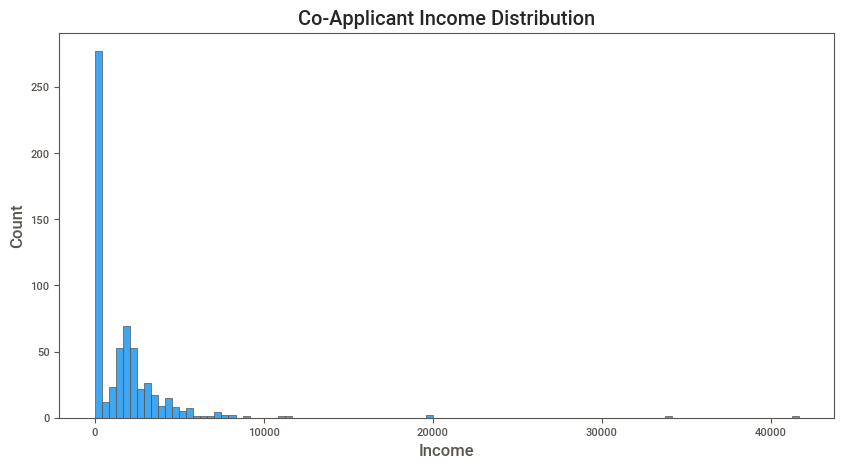

In [89]:
fig, ax = plt.subplots(figsize=(10,5))
ax.ticklabel_format(style='plain')
sns.histplot(train['CoapplicantIncome'],bins=100)
plt.title('Co-Applicant Income Distribution')
plt.xlabel('Income')
plt.show()

### Loan Amount

In [56]:
train['LoanAmount'].describe()

count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64

In [85]:
train['LoanAmount'].skew()

2.677551679256059

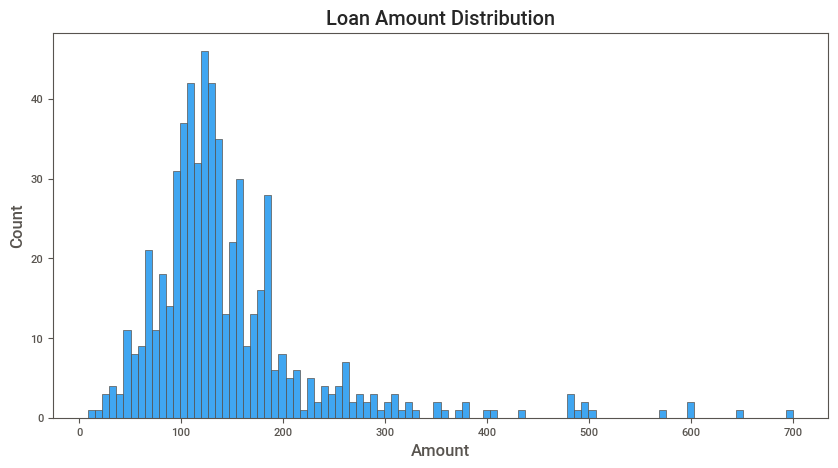

In [88]:
fig, ax = plt.subplots(figsize=(10,5))
ax.ticklabel_format(style='plain')
sns.histplot(train['LoanAmount'],bins=100)
plt.title('Loan Amount Distribution')
plt.xlabel('Amount')
plt.show()

### Loan Amount Term 

In [58]:
train['Loan_Amount_Term'].describe()

count    600.00000
mean     342.00000
std       65.12041
min       12.00000
25%      360.00000
50%      360.00000
75%      360.00000
max      480.00000
Name: Loan_Amount_Term, dtype: float64

In [86]:
train['Loan_Amount_Term'].skew()

-2.362414124216269

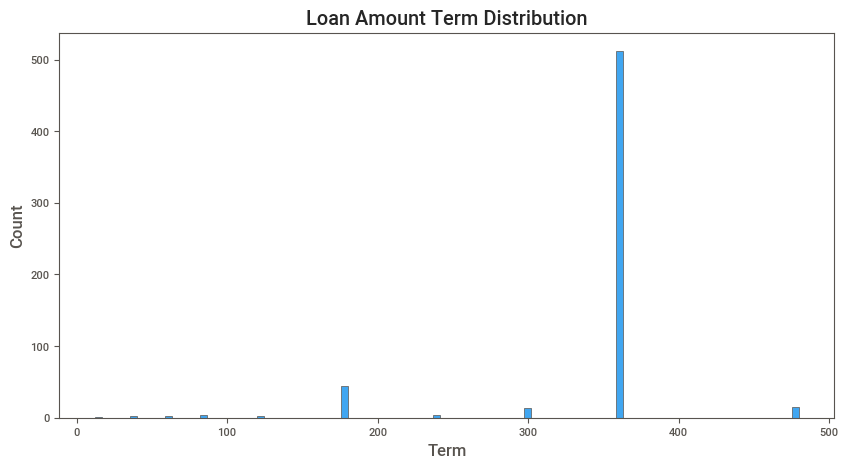

In [87]:
fig, ax = plt.subplots(figsize=(10,5))
ax.ticklabel_format(style='plain')
sns.histplot(train['Loan_Amount_Term'],bins=100)
plt.title('Loan Amount Term Distribution')
plt.xlabel('Term')
plt.show()

### Credit History

In [53]:
value_cnt_norm_cal(train, 'Credit_History')

,Count,Frequency (%)
Credit_History,,
1.0,475,84.219858
0.0,89,15.780142


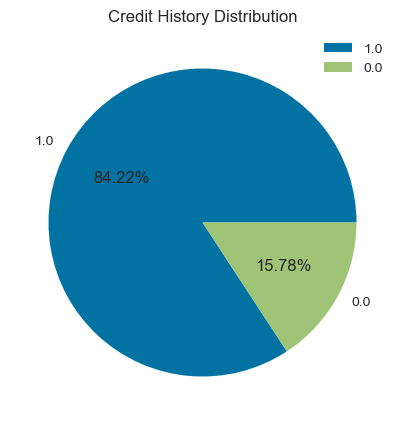

In [54]:
fig, ax = plt.subplots(figsize=(5,5))
plt.pie(train['Credit_History'].value_counts(), labels=train['Credit_History'].value_counts().index, autopct='%1.2f%%')
plt.title('Credit History Distribution')
plt.legend(loc='upper right')
plt.show()

#### Question: Are applicants with a credit history more likely to default than those who do not have one?

In [55]:
train.groupby('Credit_History')['Loan_Status'].value_counts(normalize=True)

Credit_History  Loan_Status
0.0             N              0.921348
                Y              0.078652
1.0             Y              0.795789
                N              0.204211
Name: proportion, dtype: float64

 **Overview**: There are 475 applicants who have a credit history, and there are 89 applicants without a credit history. Applicants with credit history are more likely to default.

### Loan Status (Target Variable)

In [65]:
value_cnt_norm_cal(train, 'Loan_Status')

,Count,Frequency (%)
Loan_Status,,
Y,422,68.729642
N,192,31.270358


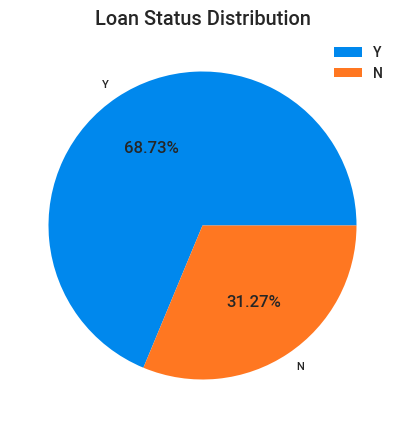

In [66]:
fig, ax = plt.subplots(figsize=(5,5))
plt.pie(train['Loan_Status'].value_counts(), labels=train['Loan_Status'].value_counts().index, autopct='%1.2f%%')
plt.title('Loan Status Distribution')
plt.legend(loc='upper right')
plt.show()

**Overview**: The majority of the loans in the dataset, approximately 68.7% (422 out of 614), have been approved, while the remaining 31.3% (192 out of 614) have been rejected. This distribution suggests that more than two-thirds of the applicants in the dataset were successful in obtaining a loan.

## Bivariate analysis

### Scatter plots

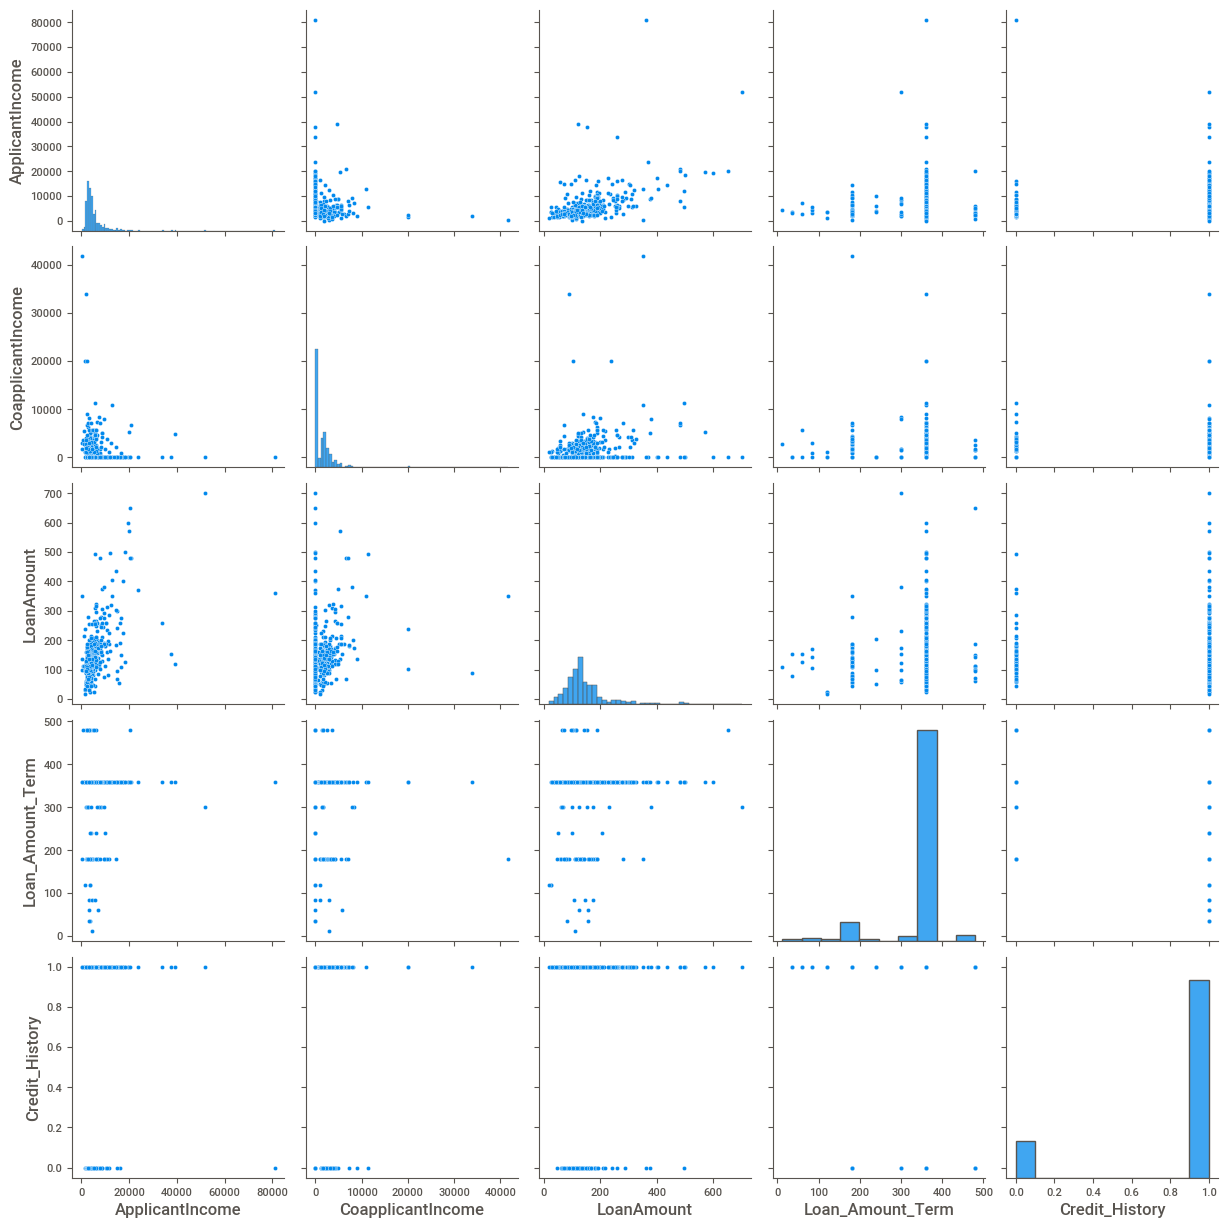

In [68]:
sns.pairplot(train_copy)
plt.show()

#### Applicant Income vs Loan Amount

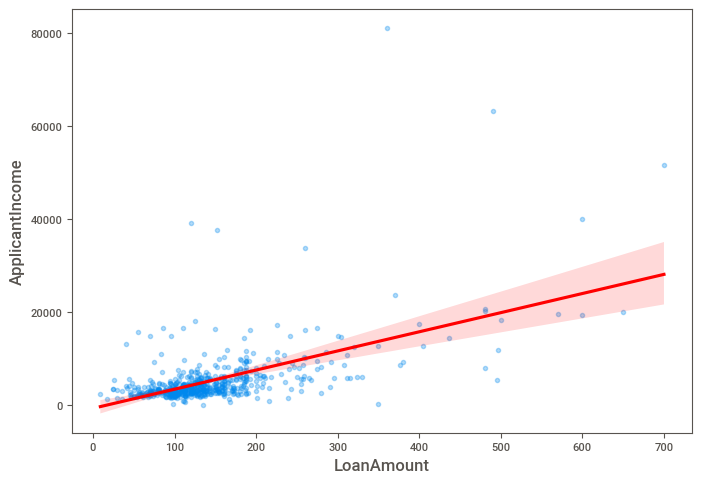

In [75]:
sns.regplot(x='LoanAmount',y='ApplicantIncome',data=train,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

In [72]:
train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

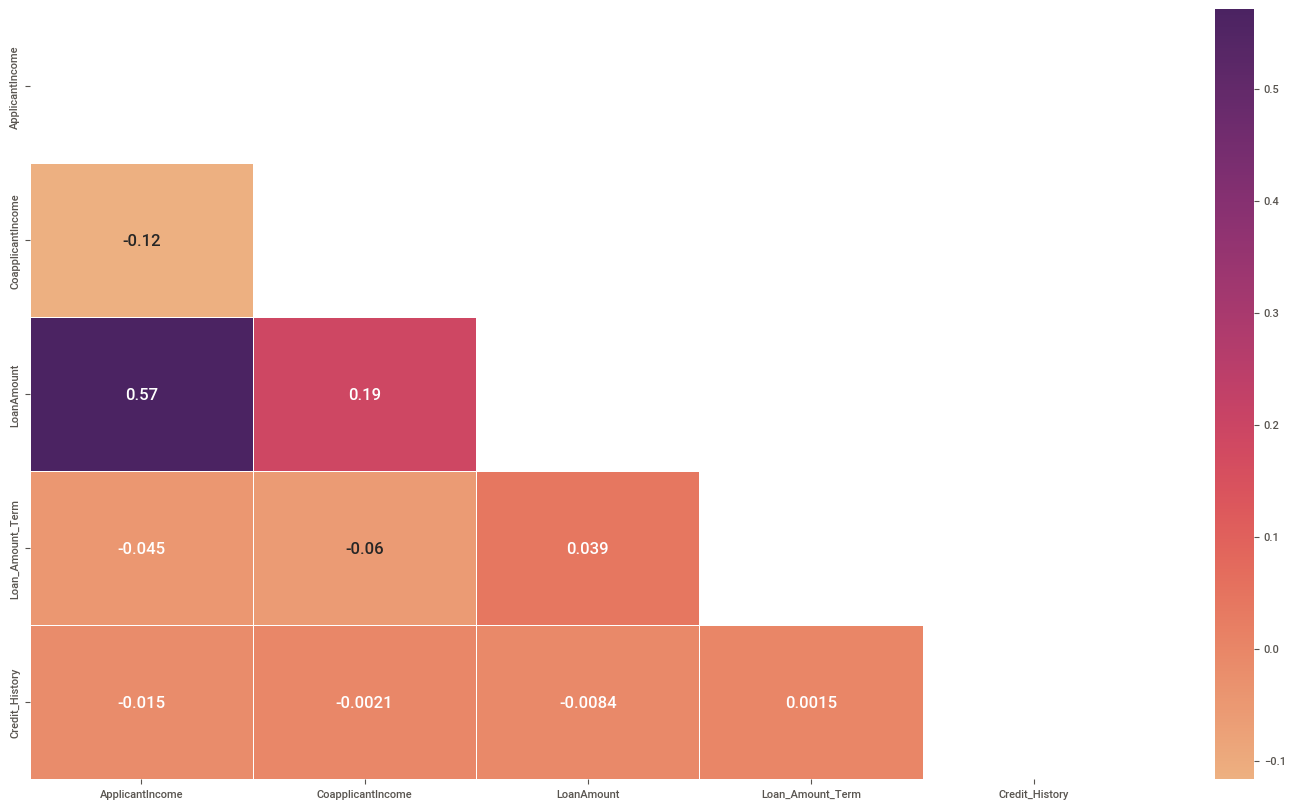

In [80]:
train_copy_corr = train.drop(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status'],axis=1).corr()
# Get the lower triangle of the correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(train_copy_corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18,10))
# seaborn heatmap
sns.heatmap(train_copy_corr, annot=True, cmap='flare',mask=mask, linewidths=.5)
# plot the heatmap
plt.show()

# Prepare the data

In [104]:
df = train[['Gender',
'Married',
'Education',
'Self_Employed',
'ApplicantIncome',
'CoapplicantIncome',
'LoanAmount',
'Loan_Amount_Term',
'Credit_History']]

## Imputing the missing values

In [106]:
# imputing the missing values:
df['Gender'].fillna(df['Gender'].mode()[0], inplace = True)
df['Married'].fillna(df['Married'].mode()[0], inplace = True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace = True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace = True)
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace = True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean(), inplace = True)

## Encoding categorical features

In [107]:
# encoding categorical features
df['Gender'] = df['Gender'].map({'Male':0,'Female':1}).astype(int)
df['Married'] = df['Married'].map({'No':0,'Yes':1}).astype(int)
df['Education'] = df['Education'].map({'Not Graduate':0,'Graduate':1}).astype(int)
df['Self_Employed'] = df['Self_Employed'].map({'No':0,'Yes':1}).astype(int)
df['Credit_History'] = df['Credit_History'].astype(int)

## Label encode target

In [108]:
X = df.copy()

# label encode target
y = train['Loan_Status'].map({'N':0,'Y':1}).astype(int)

## Train-test split

In [109]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Standard scaler

In [112]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model building

In [118]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [126]:
model_list = [
    KNeighborsClassifier(),
    GradientBoostingClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42)
]

In [127]:
for model in model_list:
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    # Check if the model has predict_proba method
    if hasattr(model, "predict_proba"):
        y_predict_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_predict_proba = model.decision_function(X_test)
    
    print(str(model))
    print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
    
    confusion_mat = confusion_matrix(y_test, y_predict)
    pre_score = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    
    print(confusion_mat)
    print('Precision Score is {:.5}'.format(pre_score))
    print('Recall Score is {:.5}'.format(recall))
    print('F1 Score is {:.5}'.format(f1))
    
    print('\n')

KNeighborsClassifier()
Accuracy Score is 0.77236
[[18 25]
 [ 3 77]]
Precision Score is 0.7549
Recall Score is 0.9625
F1 Score is 0.84615


GradientBoostingClassifier(random_state=42)
Accuracy Score is 0.7561
[[18 25]
 [ 5 75]]
Precision Score is 0.75
Recall Score is 0.9375
F1 Score is 0.83333


RandomForestClassifier(random_state=42)
Accuracy Score is 0.78049
[[19 24]
 [ 3 77]]
Precision Score is 0.76238
Recall Score is 0.9625
F1 Score is 0.85083


ExtraTreesClassifier(random_state=42)
Accuracy Score is 0.78049
[[19 24]
 [ 3 77]]
Precision Score is 0.76238
Recall Score is 0.9625
F1 Score is 0.85083




################################################################################################

## Fine tuning the mode

### Random Forest

In [123]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create a random forest classifier object
rfc = RandomForestClassifier(random_state=42)

# Perform a grid search over the hyperparameter grid using cross-validation
grid_search = GridSearchCV(rfc, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}


## Gradient Boosting Classifier

In [124]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth':[1,3,5],
    'learning_rate':[0.0001,0.001,0.01]
}

# Create a random forest classifier object
rfc = GradientBoostingClassifier(random_state=42)

# Perform a grid search over the hyperparameter grid using cross-validation
grid_search = GridSearchCV(rfc, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}


## Extra Trees

In [128]:
n_samples = X_train.shape[0]
n_features = X_train.shape[1]

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth':[None, 2,5,],
    'min_samples_split': [2, 0.5, n_samples//2, ] 
}

# Create a random forest classifier object
extra = ExtraTreesClassifier(random_state=42)

# Perform a grid search over the hyperparameter grid using cross-validation
grid_search = GridSearchCV(extra, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'max_depth': None, 'min_samples_split': 0.5, 'n_estimators': 50}


## KNN

In [130]:
param_grid = {
    'n_neighbors' : [5,7,9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']  
}

# Create a random forest classifier object
knn = KNeighborsClassifier()

# Perform a grid search over the hyperparameter grid using cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}


# Fit models 

In [135]:
final_models = [
    KNeighborsClassifier(metric='manhattan', n_neighbors=9, weights='uniform'),
    GradientBoostingClassifier(random_state=42, n_estimators=50, learning_rate=0.01, max_depth=1),
    RandomForestClassifier(random_state=42, n_estimators=50, max_depth=5, min_samples_split=5),
    ExtraTreesClassifier(random_state=42, n_estimators=50, max_depth=None, min_samples_split=0.5)
]

In [136]:
for model in final_models:
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    # Check if the model has predict_proba method
    if hasattr(model, "predict_proba"):
        y_predict_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_predict_proba = model.decision_function(X_test)
    
    print(str(model))
    print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
    
    confusion_mat = confusion_matrix(y_test, y_predict)
    pre_score = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    
    print(confusion_mat)
    print('Precision Score is {:.5}'.format(pre_score))
    print('Recall Score is {:.5}'.format(recall))
    print('F1 Score is {:.5}'.format(f1))
    
    print('\n')

KNeighborsClassifier(metric='manhattan', n_neighbors=9)
Accuracy Score is 0.79675
[[18 25]
 [ 0 80]]
Precision Score is 0.7619
Recall Score is 1.0
F1 Score is 0.86486


GradientBoostingClassifier(learning_rate=0.01, max_depth=1, n_estimators=50,
                           random_state=42)
Accuracy Score is 0.78862
[[18 25]
 [ 1 79]]
Precision Score is 0.75962
Recall Score is 0.9875
F1 Score is 0.8587


RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=50,
                       random_state=42)
Accuracy Score is 0.78049
[[18 25]
 [ 2 78]]
Precision Score is 0.75728
Recall Score is 0.975
F1 Score is 0.85246


ExtraTreesClassifier(min_samples_split=0.5, n_estimators=50, random_state=42)
Accuracy Score is 0.78862
[[18 25]
 [ 1 79]]
Precision Score is 0.75962
Recall Score is 0.9875
F1 Score is 0.8587




## Top model

Using the accuracy score and recall score, we can that conclude that our top model is:
- KNeighbors Classifier